In [1]:
from sys import path
path.append("C:\\Users\\jerem\\OneDrive - University Of Oregon\\Ion Trapping\\Dissertation")
import fit_coherent_state as fcs
import fit_squeezed_state as fss
import fit_thermal_state as fts
from qutip import *
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.optimize import curve_fit
import oitg.results as results
import os.path
from statsmodels.stats.proportion import proportion_confint
import math
import copy
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

In [2]:
def get_path(rid):
        
    for root, dirs, files in os.walk('C:\\Users\\jerem\\OneDrive - University Of Oregon\\Ion Trapping\\Dissertation\\'):
        for name in files:
            if rid in name:
                path = os.path.join(root, name)

    return path
                        
        
def get_data(path):


    data = results.load_hdf5_file(path)
    pop = data['datasets']['ndscan.points.channel_ion_bright']
    x = data['datasets']['ndscan.points.axis_0']
    
    return x, pop

def get_std(prob,N):
    std = []
    for p in prob:
        k = p*N
        confint = proportion_confint(k, N, alpha=0.3173, method='beta')
        uncertainty = (confint[1]-confint[0])/2
        std.append(uncertainty)
    return std
def line(t,m,b):
    return m*t+b

In [3]:

def SU2_calibration(delay,α,f,δ,ϕ_0,offset):
    t_rsb = 80e-6
    N = 60
    a = tensor(qeye(2),destroy(N),qeye(N))
    b = tensor(qeye(2),qeye(N),destroy(N))
    sp = tensor(sigmap(),qeye(N),qeye(N))
    sm = tensor(sigmam(),qeye(N),qeye(N))
    η1 = 0.042 
    η2 = 0.064
    
    Ω = 18.4e3*2*np.pi



    def H_a_t(t,args):
        δ = args['δ']
        return np.exp(1j*δ*t)

    def H_a_td(t,args):
        δ = args['δ']
        return np.exp(-1j*δ*t)

    def H_b_t(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(1j*(δ-diff)*t)

    def H_b_td(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(-1j*(δ-diff)*t)

    H_a1 = η1*Ω/2*(sm*a)
    H_a2 = η1*Ω/2*(sp*a.dag())

    H_b1 = η2*Ω/2*(sm*b)
    H_b2 = η2*Ω/2*(sp*b.dag())

    H = [[H_a1,H_a_t],[H_a2,H_a_td],[H_b1,H_b_t],[H_b2,H_b_td]]
    
    ψ0 = tensor(basis(2,0),basis(N,0),coherent(N,α))
    
    H_BS = (a*b.dag()+a.dag()*b)
    t_bs = np.linspace(0,np.pi/4,2)
    
    BS_1 = mesolve(H_BS,ψ0,t_bs)
    
    t_rsb = np.linspace(0,t_rsb,2)
    
    H_free = 2*np.pi*f*a.dag()*a
    free = mesolve(H_free,BS_1.states[-1],delay)
    args = {'δ':δ}
    bsp = []
    for state in free.states:
        H_BS = (a*b.dag()*np.exp(1j*ϕ_0)+a.dag()*b*np.exp(-1j*ϕ_0))
        BS2 = mesolve(H_BS,state,t_bs)
        
        rsb = mesolve(H,BS2.states[-1],t_rsb, args = args)
        bsp.append(np.real(rsb.states[-1].ptrace(0)[0,0]))
        

    bsp = 1-np.array(bsp)
    
    return bsp



[3.76828641e+00 3.03572457e+04 1.51059145e+04 3.01853373e+00
 1.00000000e-10]
[3.99677305e+00 3.02306598e+04 1.93776411e+05 2.03797142e+00
 1.00000000e-10]


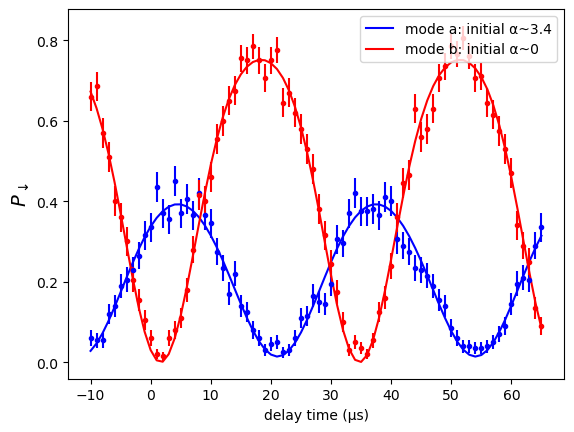

In [5]:
rids = [58523,58522]
i=0

δ_bounds_lower = [-0.1,2*np.pi*30e3]
δ_bounds_upper = [2*np.pi*3e3,2*np.pi*35e3]
cs = ['b','r']
labels = ['mode a: initial α~3.4', 'mode b: initial α~0']
fits_bs_calibration = []
f = 30e3
for rid in rids:
    ts, bp = get_data(get_path(str(int(rid))))
    bounds = ((0,29e3,δ_bounds_lower[i],1),(5,35e3,δ_bounds_upper[i],3.5))
    fit, fit_cov = curve_fit(SU2_calibration,ts,bp,bounds = bounds,p0 =[3.45,f,[0,2*np.pi*33e3][i],2.2,0] )
    fits_bs_calibration.append(fit)
    print(fit)
    plt.errorbar(ts*1e6,bp,get_std(bp,200),marker = '.',ls = 'none', c= cs[i])
    plt.plot(ts*1e6,SU2_calibration(ts,*fit), c= cs[i], label = labels[i])
    i+=1
    plt.xlabel('delay time (μs)')
    plt.ylabel(r'$P_\downarrow$',fontsize = 14)
    plt.legend();

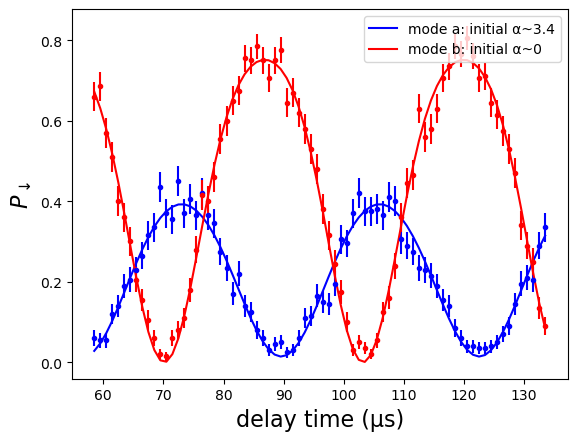

In [6]:
rids = [58523,58522]
i=0

cs = ['b','r']
labels = ['mode a: initial α~3.4', 'mode b: initial α~0']

f = 30e3
for rid in rids:
    ts, bp = get_data(get_path(str(int(rid))))
   
    plt.errorbar((ts*1e6)+68.5,bp,get_std(bp,200),marker = '.',ls = 'none', c= cs[i])
    plt.plot((ts*1e6)+68.5,SU2_calibration(ts,*fits_bs_calibration[i]), c= cs[i], label = labels[i])
    i+=1
    plt.xlabel('delay time (μs)', fontsize = 16)
    plt.ylabel(r'$P_\downarrow$',fontsize = 16)
    plt.legend();
plt.savefig('BS_calibration.pdf', format = 'pdf', bbox_inches = 'tight')

# try to get the coupling rate

In [ ]:

def SU2_calibration(delay,α,f,δ,ϕ_0,offset):
    t_rsb = 80e-6
    N = 60
    a = tensor(qeye(2),destroy(N),qeye(N))
    b = tensor(qeye(2),qeye(N),destroy(N))
    sp = tensor(sigmap(),qeye(N),qeye(N))
    sm = tensor(sigmam(),qeye(N),qeye(N))
    η1 = 0.042 
    η2 = 0.064
    
    Ω = 18.4e3*2*np.pi



    def H_a_t(t,args):
        δ = args['δ']
        return np.exp(1j*δ*t)

    def H_a_td(t,args):
        δ = args['δ']
        return np.exp(-1j*δ*t)

    def H_b_t(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(1j*(δ-diff)*t)

    def H_b_td(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(-1j*(δ-diff)*t)

    H_a1 = η1*Ω/2*(sm*a)
    H_a2 = η1*Ω/2*(sp*a.dag())

    H_b1 = η2*Ω/2*(sm*b)
    H_b2 = η2*Ω/2*(sp*b.dag())

    H = [[H_a1,H_a_t],[H_a2,H_a_td],[H_b1,H_b_t],[H_b2,H_b_td]]
    
    ψ0 = tensor(basis(2,0),basis(N,0),coherent(N,α))
    
    H_BS = (a*b.dag()+a.dag()*b)
    t_bs = np.linspace(0,np.pi/4,2)
    
    BS_1 = mesolve(H_BS,ψ0,t_bs)
    
    t_rsb = np.linspace(0,t_rsb,2)
    
    H_free = 2*np.pi*f*a.dag()*a
    free = mesolve(H_free,BS_1.states[-1],delay)
    args = {'δ':δ}
    bsp = []
    for state in free.states:
        H_BS = (a*b.dag()*np.exp(1j*ϕ_0)+a.dag()*b*np.exp(-1j*ϕ_0))
        BS2 = mesolve(H_BS,state,t_bs)
        
        rsb = mesolve(H,BS2.states[-1],t_rsb, args = args)
        bsp.append(np.real(rsb.states[-1].ptrace(0)[0,0]))
        

    bsp = 1-np.array(bsp)
    
    return bsp



# TMS+ BS results

In [4]:
def TMS_overlap(t_rsb,r,δ,Ω):
    N = 40
    a = tensor(qeye(2),destroy(N),qeye(N))
    b = tensor(qeye(2),qeye(N),destroy(N))
    sp = tensor(sigmap(),qeye(N),qeye(N))
    sm = tensor(sigmam(),qeye(N),qeye(N))

    η1 = 0.042
    η2 = 0.064


    def H_a_t(t,args):
        δ = args['δ']
        return np.exp(1j*δ*t)

    def H_a_td(t,args):
        δ = args['δ']
        return np.exp(-1j*δ*t)

    def H_b_t(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(1j*(δ-diff)*t)

    def H_b_td(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(-1j*(δ-diff)*t)

    H_a1 = η1*Ω/2*(sm*a)
    H_a2 = η1*Ω/2*(sp*a.dag())

    H_b1 = η2*Ω/2*(sm*b)
    H_b2 = η2*Ω/2*(sp*b.dag())

    H = [[H_a1,H_a_t],[H_a2,H_a_td],[H_b1,H_b_t],[H_b2,H_b_td]]

    bsp = []


    g = 1.6e3
    g = 2*np.pi*g
    H_TMS = g*(a*b+a.dag()*b.dag())
    t_TMS = np.linspace(0,r/g,2)

    args = {'δ':δ}
    ψ0 = tensor(basis(2,1),basis(N,0),basis(N,0))
    TMS_out = mesolve(H_TMS,ψ0,t_TMS)
    RSB = mesolve(H,TMS_out.states[-1],t_rsb,args = args)
    for state in RSB.states:
        bsp.append(np.real(state.ptrace(0)[0,0]))
    return np.array(bsp)

1.4002160671818293 1.7215546463098161 109.39782268453911
1.2986066693315743 31.595813489130197 118.59941160738181


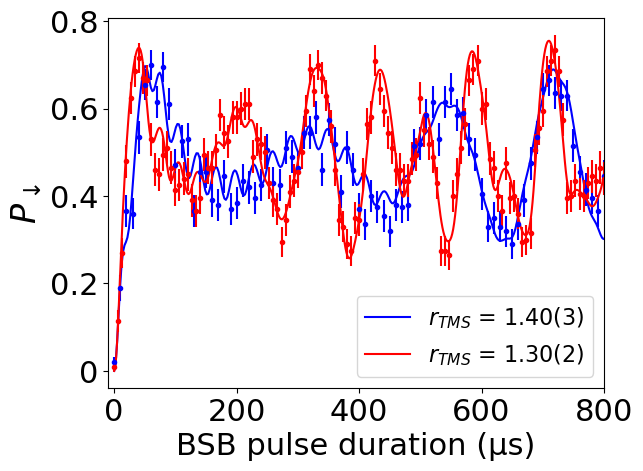

In [9]:
rids = [58554,58556]
rs = np.linspace(0.1,3,6)
δ_bounds_lower = [0,2*np.pi*30e3]
δ_bounds_upper = [2*np.pi*3e3,2*np.pi*35e3]
cs = ['b','r']
ηs = [0.042,0.064]

ts_thermal_lf, bp_thermal_lf = get_data(get_path(str(int(rids[0]))))
ts_fit_thermal_lf  = np.linspace(ts_thermal_lf[0],ts_thermal_lf[-1],501)
bounds = ((1.28,δ_bounds_lower[0],2*np.pi*105e3),(1.45,δ_bounds_upper[0],2*np.pi*120e3))
fit_lf, fit_cov_lf = curve_fit(TMS_overlap,ts_thermal_lf,bp_thermal_lf,bounds = bounds)
plt.errorbar(ts_thermal_lf*1e6,bp_thermal_lf,get_std(bp_thermal_lf,200),marker = '.',ls = 'none', c= cs[0])
plt.plot(ts_fit_thermal_lf*1e6,TMS_overlap(ts_fit_thermal_lf,*fit_lf), c= cs[0],label = r'$r_{TMS}$'+' = {:.2f}({:.0f})'.format(fit_lf[0],np.round(100*np.sqrt(np.diag(fit_cov_lf))[0])))
print(fit_lf[0],fit_lf[1]/(2*np.pi*1e3),fit_lf[2]/(2*np.pi*1e3))

ts_thermal_hf, bp_thermal_hf = get_data(get_path(str(int(rids[1]))))
ts_fit_thermal_hf  = np.linspace(ts_thermal_hf[0],ts_thermal_hf[-1],501)
bounds = ((1.28,δ_bounds_lower[1],2*np.pi*105e3),(1.45,δ_bounds_upper[1],2*np.pi*120e3))
fit_hf, fit_cov_hf = curve_fit(TMS_overlap,ts_thermal_hf,bp_thermal_hf,bounds = bounds)
plt.errorbar(ts_thermal_hf*1e6,bp_thermal_hf,get_std(bp_thermal_hf,200),marker = '.',ls = 'none', c= cs[1])
plt.plot(ts_fit_thermal_hf*1e6,TMS_overlap(ts_fit_thermal_hf,*fit_hf), c= cs[1],label = r'$r_{TMS}$'+' = {:.2f}({:.0f})'.format(fit_hf[0],np.round(100*np.sqrt(np.diag(fit_cov_hf))[0])))
print(fit_hf[0],fit_hf[1]/(2*np.pi*1e3),fit_hf[2]/(2*np.pi*1e3))

plt.xlabel('BSB pulse duration (μs)',fontsize = 22)
plt.ylabel(r'$P_\downarrow$',fontsize = 24)
plt.legend(fontsize = 16);
plt.xlim(-10,800);
plt.xticks([0,200,400,600,800],['0','200','400','600','800'],fontsize=22);
plt.yticks([0,0.2,0.4,0.6,0.8],['0','0.2','0.4','0.6','0.8'],fontsize=22);
plt.savefig('thermal_flopping.pdf', format = 'pdf',bbox_inches='tight')            

In [6]:
def SMS_overlap(t_rsb,r,δ,Ω):
    N = 40
    a = tensor(qeye(2),destroy(N),qeye(N))
    b = tensor(qeye(2),qeye(N),destroy(N))
    sp = tensor(sigmap(),qeye(N),qeye(N))
    sm = tensor(sigmam(),qeye(N),qeye(N))

    η1 = 0.042
    η2 = 0.064


    def H_a_t(t,args):
        δ = args['δ']
        return np.exp(1j*δ*t)

    def H_a_td(t,args):
        δ = args['δ']
        return np.exp(-1j*δ*t)

    def H_b_t(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(1j*(δ-diff)*t)

    def H_b_td(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(-1j*(δ-diff)*t)

    H_a1 = η1*Ω/2*(sm*a)
    H_a2 = η1*Ω/2*(sp*a.dag())

    H_b1 = η2*Ω/2*(sm*b)
    H_b2 = η2*Ω/2*(sp*b.dag())

    H = [[H_a1,H_a_t],[H_a2,H_a_td],[H_b1,H_b_t],[H_b2,H_b_td]]

    bsp = []


    g = 1.6e3
    g = 2*np.pi*g
    H_SMS = g/2*(a*a+a.dag()*a.dag())+g/2*(b*b+b.dag()*b.dag())
    t_SMS = np.linspace(0,r/g,2)

    args = {'δ':δ}
    ψ0 = tensor(basis(2,1),basis(N,0),basis(N,0))
    SMS_out = mesolve(H_SMS,ψ0,t_SMS)
    RSB = mesolve(H,SMS_out.states[-1],t_rsb,args = args)
    for state in RSB.states:
        bsp.append(np.real(state.ptrace(0)[0,0]))
    return np.array(bsp)

1.3912662392809365 2.0546840708798966 108.83298504362146
1.3044900482634096 34.396760295390166 117.80633927362894


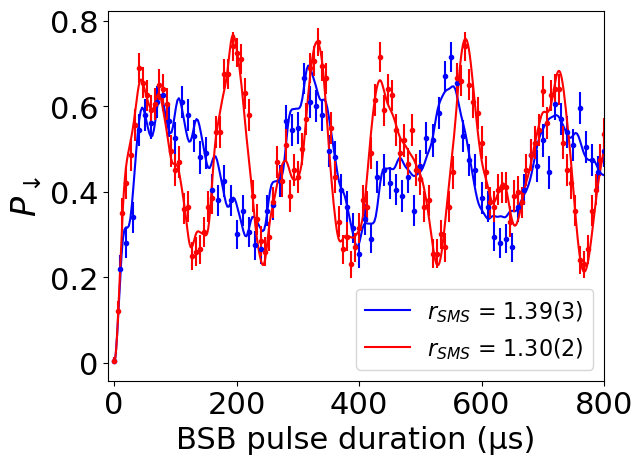

In [10]:
rids = [58558,58560]
rs = np.linspace(0.1,3,6)
δ_bounds_lower = [0,2*np.pi*30e3]
δ_bounds_upper = [2*np.pi*3e3,2*np.pi*35e3]
cs = ['b','r']
ηs = [0.042,0.064]

ts_squeezed_lf, bp_squeezed_lf = get_data(get_path(str(int(rids[0]))))
ts_fit_squeezed_lf  = np.linspace(ts_squeezed_lf[0],ts_squeezed_lf[-1],501)
bounds = ((1.28,δ_bounds_lower[0],2*np.pi*105e3),(1.4,δ_bounds_upper[0],2*np.pi*120e3))
fit_lf_sms, fit_cov_lf_sms = curve_fit(SMS_overlap,ts_squeezed_lf,bp_squeezed_lf,bounds = bounds)
plt.errorbar(ts_squeezed_lf*1e6,bp_squeezed_lf,get_std(bp_squeezed_lf,200),marker = '.',ls = 'none', c= cs[0])
plt.plot(ts_fit_squeezed_lf*1e6,SMS_overlap(ts_fit_squeezed_lf,*fit_lf_sms), c= cs[0],label = r'$r_{SMS}$'+' = {:.2f}({:.0f})'.format(fit_lf_sms[0],np.round(100*np.sqrt(np.diag(fit_cov_lf_sms))[0])))
print(fit_lf_sms[0],fit_lf_sms[1]/(2*np.pi*1e3),fit_lf_sms[2]/(2*np.pi*1e3))

ts_squeezed_hf, bp_squeezed_hf = get_data(get_path(str(int(rids[1]))))
ts_fit_squeezed_hf  = np.linspace(ts_squeezed_hf[0],ts_squeezed_hf[-1],501)
bounds = ((1.28,δ_bounds_lower[1],2*np.pi*113e3),(1.4,δ_bounds_upper[1],2*np.pi*120e3))
fit_hf_sms, fit_cov_hf_sms = curve_fit(SMS_overlap,ts_squeezed_hf,bp_squeezed_hf,bounds = bounds)
plt.errorbar(ts_squeezed_hf*1e6,bp_squeezed_hf,get_std(bp_squeezed_hf,200),marker = '.',ls = 'none', c= cs[1])
plt.plot(ts_fit_squeezed_hf*1e6,SMS_overlap(ts_fit_squeezed_hf,*fit_hf_sms), c= cs[1],label = r'$r_{SMS}$'+' = {:.2f}({:.0f})'.format(fit_hf_sms[0],np.round(100*np.sqrt(np.diag(fit_cov_hf_sms))[0])))
print(fit_hf_sms[0],fit_hf_sms[1]/(2*np.pi*1e3),fit_hf_sms[2]/(2*np.pi*1e3))

plt.xlabel('BSB pulse duration (μs)',fontsize = 22)
plt.ylabel(r'$P_\downarrow$',fontsize = 24)
plt.legend(fontsize = 16);
plt.xlim(-10,800);
plt.xticks([0,200,400,600,800],['0','200','400','600','800'],fontsize=22);
plt.yticks([0,0.2,0.4,0.6,0.8],['0','0.2','0.4','0.6','0.8'],fontsize=22);
plt.savefig('Squeezed_flopping.pdf', format = 'pdf',bbox_inches='tight')               

1.3599999999999999 2.0793039591672424 108.73028865168662
1.3400000000000003 34.30609565792605 118.0088457592519


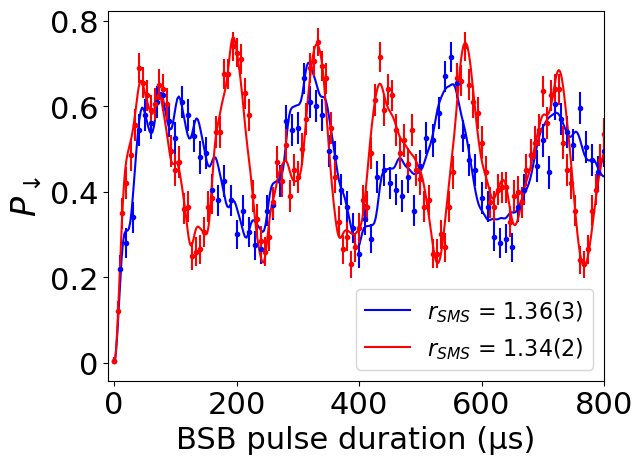

In [30]:
rids = [58558,58560]
rs = np.linspace(0.1,3,6)
δ_bounds_lower = [0,2*np.pi*30e3]
δ_bounds_upper = [2*np.pi*3e3,2*np.pi*35e3]
cs = ['b','r']
ηs = [0.042,0.064]

ts_squeezed_lf, bp_squeezed_lf = get_data(get_path(str(int(rids[0]))))
ts_fit_squeezed_lf  = np.linspace(ts_squeezed_lf[0],ts_squeezed_lf[-1],501)
bounds = ((1.34,δ_bounds_lower[0],2*np.pi*105e3),(1.36,δ_bounds_upper[0],2*np.pi*120e3))
fit_lf_sms, fit_cov_lf_sms = curve_fit(SMS_overlap,ts_squeezed_lf,bp_squeezed_lf,bounds = bounds)
plt.errorbar(ts_squeezed_lf*1e6,bp_squeezed_lf,get_std(bp_squeezed_lf,200),marker = '.',ls = 'none', c= cs[0])
plt.plot(ts_fit_squeezed_lf*1e6,SMS_overlap(ts_fit_squeezed_lf,*fit_lf_sms), c= cs[0],label = r'$r_{SMS}$'+' = {:.2f}({:.0f})'.format(fit_lf_sms[0],np.round(100*np.sqrt(np.diag(fit_cov_lf_sms))[0])))
print(fit_lf_sms[0],fit_lf_sms[1]/(2*np.pi*1e3),fit_lf_sms[2]/(2*np.pi*1e3))

ts_squeezed_hf, bp_squeezed_hf = get_data(get_path(str(int(rids[1]))))
ts_fit_squeezed_hf  = np.linspace(ts_squeezed_hf[0],ts_squeezed_hf[-1],501)
bounds = ((1.34,δ_bounds_lower[1],2*np.pi*113e3),(1.36,δ_bounds_upper[1],2*np.pi*120e3))
fit_hf_sms, fit_cov_hf_sms = curve_fit(SMS_overlap,ts_squeezed_hf,bp_squeezed_hf,bounds = bounds)
plt.errorbar(ts_squeezed_hf*1e6,bp_squeezed_hf,get_std(bp_squeezed_hf,200),marker = '.',ls = 'none', c= cs[1])
plt.plot(ts_fit_squeezed_hf*1e6,SMS_overlap(ts_fit_squeezed_hf,*fit_hf_sms), c= cs[1],label = r'$r_{SMS}$'+' = {:.2f}({:.0f})'.format(fit_hf_sms[0],np.round(100*np.sqrt(np.diag(fit_cov_hf_sms))[0])))
print(fit_hf_sms[0],fit_hf_sms[1]/(2*np.pi*1e3),fit_hf_sms[2]/(2*np.pi*1e3))

plt.xlabel('BSB pulse duration (μs)',fontsize = 22)
plt.ylabel(r'$P_\downarrow$',fontsize = 24)
plt.legend(fontsize = 16);
plt.xlim(-10,800);
plt.xticks([0,200,400,600,800],['0','200','400','600','800'],fontsize=22);
plt.yticks([0,0.2,0.4,0.6,0.8],['0','0.2','0.4','0.6','0.8'],fontsize=22);
plt.savefig('Squeezed_flopping.pdf', format = 'pdf',bbox_inches='tight')               

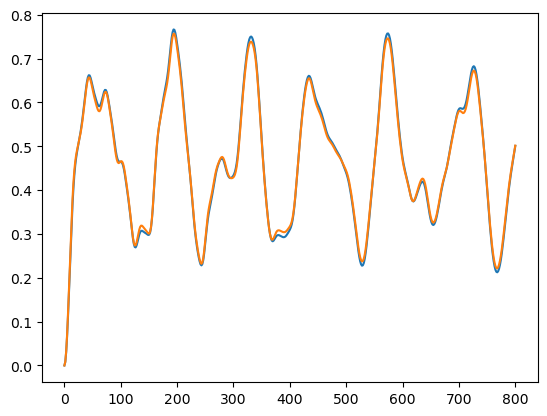

In [29]:
test1 = np.array([1.30448935e+00, 2.16121262e+05, 7.40198919e+05])
test2 = np.array([1.34, 2.16121262e+05, 7.40198919e+05])
plt.plot(ts_fit_squeezed_hf*1e6,SMS_overlap(ts_fit_squeezed_hf,*test1))
plt.plot(ts_fit_squeezed_hf*1e6,SMS_overlap(ts_fit_squeezed_hf,*test2))

In [27]:
fit_hf_sms

array([1.30448935e+00, 2.16121262e+05, 7.40198919e+05])

In [32]:
np.sqrt(np.diag(fit_cov_lf_sms))

array([3.05481245e-02, 3.21122442e+02, 1.97564057e+03])

In [33]:
np.sqrt(np.diag(fit_cov_hf_sms))

array([2.25817984e-02, 6.33494105e+02, 1.59871263e+03])

In [19]:
int(100*np.sqrt(np.diag(fit_cov_lf))[0])

2

In [21]:
100*np.sqrt(np.diag(fit_cov_lf))[0]

2.8217076658648144

In [35]:
np.round(np.sqrt(np.diag(fit_cov_lf))[0],2)

0.03

In [34]:
np.sqrt(np.diag(fit_cov_hf_sms))

array([2.25817984e-02, 6.33494105e+02, 1.59871263e+03])

# fock state fits

In [11]:
def SMS_overlap_individual(t_rsb,r,δ,Ω,n,pn, mode = 'lf'):
    N = 40
    a = tensor(qeye(2),destroy(N),qeye(N))
    b = tensor(qeye(2),qeye(N),destroy(N))
    sp = tensor(sigmap(),qeye(N),qeye(N))
    sm = tensor(sigmam(),qeye(N),qeye(N))

    η1 = 0.042
    η2 = 0.064


    def H_a_t(t,args):
        δ = args['δ']
        return np.exp(1j*δ*t)

    def H_a_td(t,args):
        δ = args['δ']
        return np.exp(-1j*δ*t)

    def H_b_t(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(1j*(δ-diff)*t)

    def H_b_td(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(-1j*(δ-diff)*t)

    H_a1 = η1*Ω/2*(sm*a)
    H_a2 = η1*Ω/2*(sp*a.dag())

    H_b1 = η2*Ω/2*(sm*b)
    H_b2 = η2*Ω/2*(sp*b.dag())

    H = [[H_a1,H_a_t],[H_a2,H_a_td],[H_b1,H_b_t],[H_b2,H_b_td]]

    bsp = []


    g = 1.6e3
    g = 2*np.pi*g
    H_SMS = g/2*(a*a+a.dag()*a.dag())+g/2*(b*b+a.dag()*a.dag())
    t_SMS = np.linspace(0,r/g,2)

    args = {'δ':δ}
    ψ0 = tensor(basis(2,1),basis(N,0),basis(N,0))
    SMS_out = mesolve(H_SMS,ψ0,t_SMS)
    mode_a = np.sqrt(np.array(SMS_out.states[-1].ptrace(1).diag()))
    mode_b = np.sqrt(np.array(SMS_out.states[-1].ptrace(2).diag()))
    if mode == 'lf':
        mode_a[n] = np.sqrt(pn)
    else:
        mode_b[n] = np.sqrt(pn)
    ψ_sms = tensor(basis(2,1),Qobj(mode_a).unit(),Qobj(mode_b).unit())
    RSB = mesolve(H,ψ_sms,t_rsb,args = args)
    for state in RSB.states:
        bsp.append(np.real(state.ptrace(0)[0,0]))
    return np.array(bsp)

In [36]:
vals_squeeze = ket2dm(squeeze(40,1.35)*basis(40,0)).diag()
i = 0
pns_a_sms = []
pns_a_cov_sms = []
for n in range(25):
    bounds = ((vals_squeeze[i]*0.98),(vals_squeeze[i]*1.02+0.001))
    fit_test, fit_test_cov = curve_fit(lambda ts, pn: SMS_overlap_individual(ts,*fit_lf_sms,n,pn),ts_squeezed_lf,bp_squeezed_lf,sigma = get_std(bp_squeezed_lf,200), bounds = bounds)
    pns_a_sms.append(fit_test[0])
    pns_a_cov_sms.append(np.sqrt(np.diag(fit_test_cov))[0])
    i+=1
    print(i)

i = 0

pns_b_sms = []
pns_b_cov_sms = []
for n in range(25):
    bounds = ((vals_squeeze[i]*0.98),(vals_squeeze[i]*1.02+0.001))
    fit_test, fit_test_cov = curve_fit(lambda ts, pn: SMS_overlap_individual(ts,*fit_lf_sms,n,pn,mode = 'hf'),ts_squeezed_lf,bp_squeezed_lf,sigma = get_std(bp_squeezed_lf,200), bounds = bounds)
    pns_b_sms.append(fit_test[0])
    pns_b_cov_sms.append(np.sqrt(np.diag(fit_test_cov))[0])
    i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [ ]:
vals_squeeze = ket2dm(squeeze(40,1.35)*basis(40,0)).diag()
i = 0
pns_a_sms_bflop = []
pns_a_cov_sms_bflop = []
for n in range(25):
    bounds = ((vals_squeeze[i]*0.98),(vals_squeeze[i]*1.02+0.001))
    fit_test, fit_test_cov = curve_fit(lambda ts, pn: SMS_overlap_individual(ts,*fit_hf_sms,n,pn),ts_squeezed_hf,bp_squeezed_hf,sigma = get_std(bp_squeezed_hf,200), bounds = bounds)
    pns_a_sms_bflop.append(fit_test[0])
    pns_a_cov_sms_bflop.append(np.sqrt(np.diag(fit_test_cov))[0])
    i+=1

i = 0

pns_b_sms_bflop = []
pns_b_cov_sms_bflop = []
for n in range(25):
    bounds = ((vals_squeeze[i]*0.98),(vals_squeeze[i]*1.02+0.001))
    fit_test, fit_test_cov = curve_fit(lambda ts, pn: SMS_overlap_individual(ts,*fit_hf_sms,n,pn,mode = 'hf'),ts_squeezed_hf,bp_squeezed_hf,sigma = get_std(bp_squeezed_hf,200), bounds = bounds)
    pns_b_sms_bflop.append(fit_test[0])
    pns_b_cov_sms_bflop.append(np.sqrt(np.diag(fit_test_cov))[0])
    i+=1

In [ ]:
N = 20     
ns = np.linspace(0,N-1,N)
Ni_a = np.linspace(0,N-1,N)
pn_a = np.array(pns_a_sms)
Pierr_a = np.array(pns_a_cov_sms)
plt.figure(num=None, figsize=(8, 2), dpi=80, facecolor='w', edgecolor='k')
#plt.plot(self.Ni,self.pcoh)
plt.bar(Ni_a,pn_a,yerr=Pierr_a ,facecolor='blue',width=0.70, alpha=0.5,align='center',error_kw=dict(ecolor='navy', lw=2, capsize=4, capthick=1),label='Data',edgecolor='navy')


fit_pops_thermal, fit_pop_thermal_cov = curve_fit(squeezed_state,2*ns,pn_a,sigma = Pierr_a,bounds = ((1.34),(1.38)))
plt.plot(ns,fix_squeeze(squeezed_state(ns,*fit_pops_thermal))[:len(ns)],color = 'k',label = r'$r$ = '+'{:.2f}'.format(fit_pops_thermal[0]))

plt.xlabel(r'n', fontsize=20)
plt.ylabel('p(n)', fontsize=20)
plt.xticks(np.arange(0, N, step=5),fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlim([-1,N])
plt.ylim([-0.05,.6])
plt.grid(True, which='both', color='0.65', linestyle='--')
plt.savefig('LF_squeezed.pdf', format = 'pdf',bbox_inches='tight')


In [37]:
def TMS_overlap_individual(t_rsb,r,δ,Ω,n,pn, mode = 'lf'):
    N = 40
    a = tensor(qeye(2),destroy(N),qeye(N))
    b = tensor(qeye(2),qeye(N),destroy(N))
    sp = tensor(sigmap(),qeye(N),qeye(N))
    sm = tensor(sigmam(),qeye(N),qeye(N))

    η1 = 0.042
    η2 = 0.064


    def H_a_t(t,args):
        δ = args['δ']
        return np.exp(1j*δ*t)

    def H_a_td(t,args):
        δ = args['δ']
        return np.exp(-1j*δ*t)

    def H_b_t(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(1j*(δ-diff)*t)

    def H_b_td(t,args):
        δ = args['δ']
        diff = 2*np.pi*33e3
        return np.exp(-1j*(δ-diff)*t)

    H_a1 = η1*Ω/2*(sm*a)
    H_a2 = η1*Ω/2*(sp*a.dag())

    H_b1 = η2*Ω/2*(sm*b)
    H_b2 = η2*Ω/2*(sp*b.dag())

    H = [[H_a1,H_a_t],[H_a2,H_a_td],[H_b1,H_b_t],[H_b2,H_b_td]]

    bsp = []


    g = 1.6e3
    g = 2*np.pi*g
    H_TMS = g*(a*b+a.dag()*b.dag())
    t_TMS = np.linspace(0,r/g,2)

    args = {'δ':δ}
    ψ0 = tensor(basis(2,1),basis(N,0),basis(N,0))
    TMS_out = mesolve(H_TMS,ψ0,t_TMS)
    mode_a = np.sqrt(np.array(TMS_out.states[-1].ptrace(1).diag()))
    mode_b = np.sqrt(np.array(TMS_out.states[-1].ptrace(2).diag()))
    if mode == 'lf':
        mode_a[n] = np.sqrt(pn)
    else:
        mode_b[n] = np.sqrt(pn)
    ψ_tms = tensor(basis(2,1),Qobj(mode_a).unit(),Qobj(mode_b).unit())
    RSB = mesolve(H,ψ_tms,t_rsb,args = args)
    for state in RSB.states:
        bsp.append(np.real(state.ptrace(0)[0,0]))
    return np.array(bsp)

In [38]:
vals_thermal = thermal_dm(25,3.23).diag()
i = 0

pns_a = []
pns_a_cov = []
for n in range(25):
    bounds = ((vals_thermal[i]*0.95),(vals_thermal[i]*1.05))
    fit_test, fit_test_cov = curve_fit(lambda ts, pn: TMS_overlap_individual(ts,*fit_lf,n,pn),ts_thermal_lf,bp_thermal_lf,sigma = get_std(bp_thermal_lf,200), bounds = bounds)
    pns_a.append(fit_test[0])
    pns_a_cov.append(np.sqrt(np.diag(fit_test_cov))[0])
    i+=1
i = 0

pns_b = []
pns_b_cov = []
for n in range(25):
    bounds = ((vals_thermal[i]*0.95),(vals_thermal[i]*1.05))
    fit_test, fit_test_cov = curve_fit(lambda ts, pn: TMS_overlap_individual(ts,*fit_lf,n,pn,mode = 'hf'),ts_thermal_lf,bp_thermal_lf,sigma = get_std(bp_thermal_lf,200), bounds = bounds)
    pns_b.append(fit_test[0])
    pns_b_cov.append(np.sqrt(np.diag(fit_test_cov))[0])
    i+=1

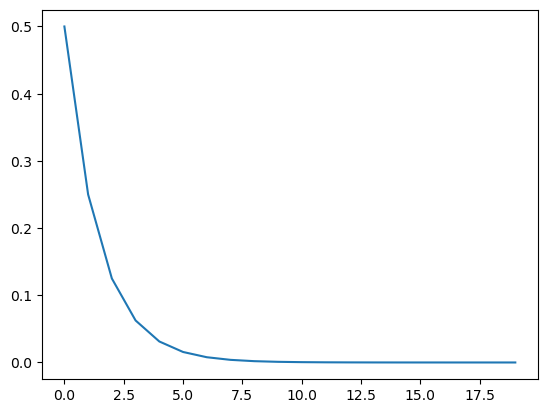

In [39]:
def thermal_state(n,nbar):
    Pn = (1/(nbar+1))*(nbar/(1+nbar))**n
    return Pn
ns = np.linspace(0,19,20)
plt.plot(ns,thermal_state(ns,1))

In [89]:

t_rsb = 80e-6
N = 60
a = tensor(qeye(2),destroy(N),qeye(N))
b = tensor(qeye(2),qeye(N),destroy(N))
sp = tensor(sigmap(),qeye(N),qeye(N))
sm = tensor(sigmam(),qeye(N),qeye(N))
η1 = 0.042 
η2 = 0.064

Ω = 18.4e3*2*np.pi

α = 3.4
ϕ_0=0

def H_a_t(t,args):
    δ = args['δ']
    return np.exp(1j*δ*t)

def H_a_td(t,args):
    δ = args['δ']
    return np.exp(-1j*δ*t)

def H_b_t(t,args):
    δ = args['δ']
    diff = 2*np.pi*33e3
    return np.exp(1j*(δ-diff)*t)

def H_b_td(t,args):
    δ = args['δ']
    diff = 2*np.pi*33e3
    return np.exp(-1j*(δ-diff)*t)

H_a1 = η1*Ω/2*(sm*a)
H_a2 = η1*Ω/2*(sp*a.dag())

H_b1 = η2*Ω/2*(sm*b)
H_b2 = η2*Ω/2*(sp*b.dag())

H = [[H_a1,H_a_t],[H_a2,H_a_td],[H_b1,H_b_t],[H_b2,H_b_td]]

ψ0 = tensor(basis(2,0),coherent(N,α),basis(N,0))
gs = np.linspace(0,1,20)
bsp = []
for g in gs:
    print(g)
    H_BS = g*(a*b.dag()+a.dag()*b)
    t_bs = np.linspace(0,np.pi,2)
    args = {'δ':2*np.pi*33e3}
    BS_1 = mesolve(H_BS,ψ0,t_bs, options = Options(nsteps = 1e5))
    
    t_rsb = np.linspace(0,t_rsb,2)
    H_BS = g*(a*b.dag()*np.exp(1j*ϕ_0)+a.dag()*b*np.exp(-1j*ϕ_0))
    BS2 = mesolve(H_BS,BS_1.states[-1],t_bs, options = Options(nsteps = 1e5))
    
    rsb = mesolve(H,BS_1.states[-1],t_rsb, args = args)
    bsp.append(1-np.real(rsb.states[-1].ptrace(0)[0,0]))
    




0.0
0.05263157894736842
0.10526315789473684
0.15789473684210525
0.21052631578947367
0.2631578947368421
0.3157894736842105
0.3684210526315789
0.42105263157894735
0.47368421052631576
0.5263157894736842
0.5789473684210527
0.631578947368421
0.6842105263157894
0.7368421052631579
0.7894736842105263
0.8421052631578947
0.894736842105263
0.9473684210526315
1.0


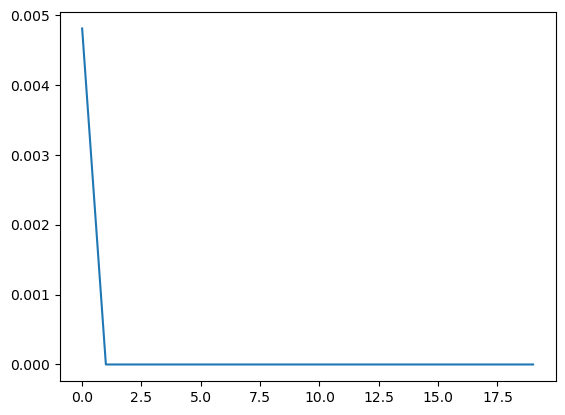

In [90]:
plt.plot(bsp)

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='Fock number', ylabel='Occupation probability'>)

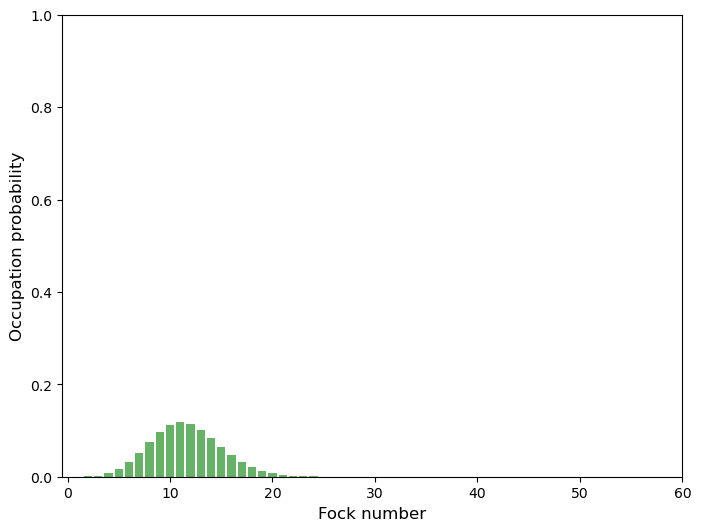

In [87]:
plot_fock_distribution(rsb.states[-1].ptrace(1))

In [75]:
bsp

[0.004812628313770606,
 -2.220446049250313e-16,
 2.220446049250313e-16,
 0.0,
 -4.440892098500626e-16,
 -6.661338147750939e-16,
 0.0,
 -4.440892098500626e-16,
 0.0,
 0.0]

In [117]:


N = 60
a = tensor(destroy(N),qeye(N))
b = tensor(qeye(N),destroy(N))




α = 3.4




ψ0 = tensor(coherent(N,α),basis(N,0))
gs = np.linspace(0,2*np.pi*0.7e3,81)
α_f = []
for g in gs:
    H_BS = g*(a*b.dag()+a.dag()*b)
    t_bs = np.linspace(0,30/76e3,2)
    BS1 = mesolve(H_BS,ψ0,t_bs, options = Options(nsteps = 1e5))
   
    BS2 = mesolve(H_BS,BS1.states[-1],t_bs, options = Options(nsteps = 1e5))
    
    α_f.append(np.sqrt(expect(a.dag()*a,BS2.states[-1])))
    




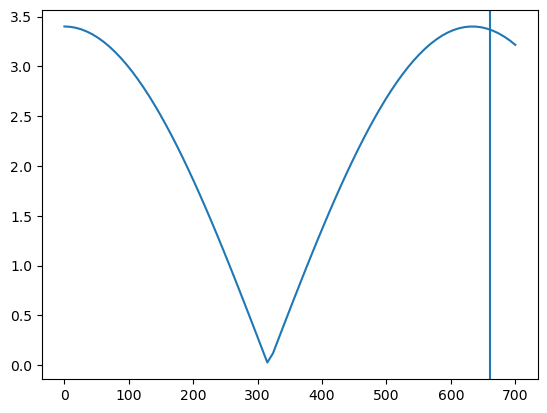

In [119]:
plt.plot(gs/(2*np.pi),α_f)
plt.axvline(660)

In [105]:
0.258/2

0.129

In [106]:
.129/.101

1.2772277227722773

In [116]:
1.27*560

711.2